In [1]:
import pandas as pd
import numpy as np
import pymorphy2
import re
import os
import json
import matplotlib.pyplot as plt

In [25]:
#Парсинг данных и формирование данных в конце файла
#Чтение данных из json, сформированном заранее
songs_from_json = []
with open("results_songs.json", "r", encoding="utf-8") as f:
    songs_json = json.load(f)
    for song in songs_json:

        songs_from_json.append([song['title'], song['lyrics'], song['genre']])
songs = pd.DataFrame(data = songs_from_json, columns = ['title', 'lyrics', 'genre'])
# news.head()
songs

,title,lyrics,genre
0,Пора возвращаться домой (Time To Go Home),[Текст песни «Пора возвращаться домой» ft. Oxx...,0
1,Полковнику никто не пишет (Nobody Writes to th...,[Текст песни «Полковнику никто не пишет»][Купл...,0
2,Чёрное солнце (Black sun),[Текст песни «Чёрное солнце»][Куплет 1]В багро...,0
3,Мой рок-н-ролл (My Rock & Roll),"[Текст песни «Мой рок-н-ролл»][Куплет 1]И то, ...",0
4,Варвара (Varvara),"[Текст песни «Варвара»][Интро]Ну, где ты, Варв...",0
...,...,...,...
1327,Hard 2 Kill,"*DJ Tape*[Бридж: Big Baby Tape]Baby Tape, я Ha...",3
1328,Broke Day,[Текст песни «Broke Day»][Интро: Big Baby Tape...,3
1329,Vampire Type Bitch,[Текст песни «Vampire Type Bitch» ft. Dope V][...,3
1330,Slip & Slide,[Текст песни «Slip & Slide»][Интро: kizaru & B...,3


In [3]:
songs.shape

(1332, 2)

In [4]:
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors

In [5]:
model_w2v = KeyedVectors.load_word2vec_format('araneum_upos_skipgram_300_2_2018.vec.gz')

In [6]:

POS = {'ADJF':'ADJ', 'ADJS':'ADJ', 'ADV':'ADV', 'NOUN':'NOUN', 
            'VERB':'VERB', 'PRTF':'ADJ', 'PRTS':'ADJ', 'GRND':'VERB'}

cashed_words = {}
nones = {} 

morph = pymorphy2.MorphAnalyzer()

def normalizeTextByPOS(text):
    tokens = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', text)
    words = []
    for t in tokens:
        if t in cashed_words.keys():
            words.append(cashed_words[t])
        elif t in nones.keys():
            pass
        else:
            pv = morph.parse(t)
            if pv[0].tag.POS != None:
                if pv[0].tag.POS in POS.keys():
                    word = pv[0].normal_form + "_" + POS[pv[0].tag.POS]
                    words.append(word)
                    cashed_words[t] = word
                else:
                    nones[t] = ""
                    
    return words

In [7]:
index2word_set = set(model_w2v.index_to_key)

def vectorize(text):
    vector = np.zeros((model_w2v.vector_size,), dtype="float32")
    n_words = 0

    for word in normalizeTextByPOS(text):
        if word in index2word_set:
            n_words = n_words + 1
            vector = np.add(vector, model_w2v[word]) 
    
    if n_words != 0:
        vector /= n_words
    return vector

In [34]:
w2v_vectors = [vectorize(text) for text in songs.lyrics]

In [9]:
from umap.umap_ import UMAP

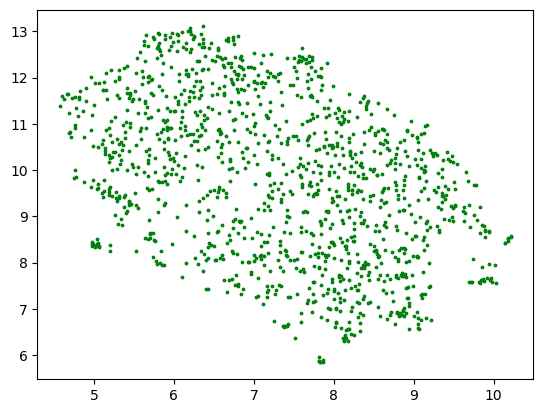

In [35]:
from umap.umap_ import UMAP
umap_news = UMAP()
umaped_vct = umap_news.fit_transform(w2v_vectors)
fig, ax = plt.subplots()
ax.scatter(umaped_vct[:, 0], umaped_vct[:, 1], edgecolor='g', s=3)
plt.show()

In [37]:
#import seaborn as sns
from matplotlib.colors import ListedColormap
#from numpy.random import choice
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import KMeans

In [58]:
crit = []

max_num = 12
for k in range(2, max_num):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(umaped_vct)
    crit.append(np.sqrt(kmeans.inertia_))

def elbow_demo(k=2):
    
    kmeans = KMeans(n_clusters=k, random_state=1).fit(umaped_vct)
    
    fig, ax = plt.subplots(1,2)
    
    ax[0].scatter(umaped_vct[:, 0], umaped_vct[:, 1], c=kmeans.labels_)
    #y = kmeans.labels_
    
    ax[0].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
                  marker='o', c="white", alpha=1, s=200)
    
    ax[0].set_xlabel('$x_1$')
    ax[0].set_ylabel('$x_2$')

    for i, c in enumerate(kmeans.cluster_centers_):
        ax[0].scatter(c[0], c[1], marker=f'${i}$', alpha=1, s=50)
        
    ax[1].scatter(k, crit[k-2], color='g', marker='s', s=90)
    ax[1].plot(range(2,max_num), crit, marker='s')
    
    ax[1].set_xlabel('$k$')
    ax[1].set_ylabel('$L^{(k)}(C)$')
    
    plt.show()
    


In [59]:
from ipywidgets import interact, IntSlider, fixed, FloatSlider
interact(elbow_demo, k=IntSlider(min=2,max=10,step=1,value=2));

interactive(children=(IntSlider(value=2, description='k', max=10, min=2), Output()), _dom_classes=('widget-int…

In [60]:
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(kmeans.labels_, songs.lyrics)

0.0016755324213560709

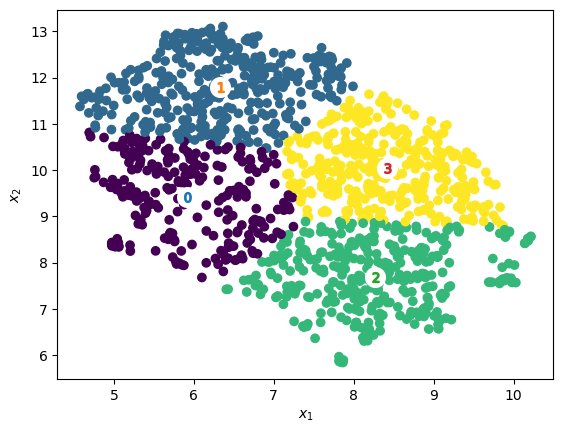

In [100]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=1).fit(umaped_vct)
crit.append(np.sqrt(kmeans.inertia_))
y = kmeans.labels_

fig, ax = plt.subplots(1,1)

ax.scatter(umaped_vct[:, 0], umaped_vct[:, 1], c=kmeans.labels_)
#y = kmeans.labels_

ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
              marker='o', c="white", alpha=1, s=200)

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
for i, c in enumerate(kmeans.cluster_centers_):
    ax.scatter(c[0], c[1], marker=f'${i}$', alpha=1, s=50)

plt.show()

In [62]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [63]:
X_train, X_test, y_train, y_test = train_test_split(umaped_vct, y, test_size=0.8)

In [64]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='euclidean')
knn.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean')

In [65]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)


y_hat2=knn.predict(X_test)

In [66]:
def calc_prec(y_hat2, y_test):
    prec=0
    for i, j in zip(y_hat2, y_test):
        if i==j:
            prec+=1
    prec/=len(y_test)
    return prec

calc_prec(y_hat2, y_test)

0.958930276981853

In [27]:
k = 0
indexes = []
for i in kmeans.labels_:
    if i == 2:
        indexes.append(k)
    k+= 1
indexes

[146,
 147,
 209,
 632,
 655,
 664,
 679,
 681,
 682,
 683,
 690,
 699,
 722,
 774,
 775,
 788,
 867,
 872,
 929,
 937,
 976,
 1013,
 1054,
 1115]

In [29]:
for ind in indexes:
    print(songs.iloc[ind])

title                                               No good
lyrics    [Verse 1]'Cause the way you found meKept alone...
genre                                                     0
Name: 146, dtype: object
title                               You’d Better Believe Me
lyrics    [Verse 1]They called me the "Iron Snake"Tombed...
genre                                                     0
Name: 147, dtype: object
title                          Blood Type [English version]
lyrics    [Verse 1]It's such a warm placeBut there on th...
genre                                                     0
Name: 209, dtype: object
title                                      Nie lekceważ nas
lyrics    [Verse 1: Pono]Wszyscy co nam źle życzyli, mów...
genre                                                     1
Name: 632, dtype: object
title                                               Believe
lyrics    [Verse 1]Even when the thunder and storm begin...
genre                                                     2


In [81]:
# songs.drop(songs.index[pos], inplace=True)
# songs = songs.drop(index = indexes)
#songs[songs["genre"]==0] # 314
#songs[songs["genre"]==1] # 336
#songs[songs["genre"]==2] # 265
songs[songs["genre"]==3] #393


,title,lyrics,genre
934,Cristal & МОЁТ (Remix),[Текст песни «Cristal & МОЁТ (Remix)»][Интро: ...,3
935,Добро Пожаловать (Welcome),[Текст песни «Добро Пожаловать»][Интро: OG Bud...,3
936,Старшие (Elders),[Текст песни «Старшие» ft. Polyana][Интро: OG ...,3
938,Сайфер (Cypher),"[Текст песни «Сайфер» ft. ЕГОР КРИД, SODA LUV...",3
939,На чиле (Chilling),"[Текст песни «На чиле» ft. ЕГОР КРИД, The Limb...",3
...,...,...,...
1327,Hard 2 Kill,"*DJ Tape*[Бридж: Big Baby Tape]Baby Tape, я Ha...",3
1328,Broke Day,[Текст песни «Broke Day»][Интро: Big Baby Tape...,3
1329,Vampire Type Bitch,[Текст песни «Vampire Type Bitch» ft. Dope V][...,3
1330,Slip & Slide,[Текст песни «Slip & Slide»][Интро: kizaru & B...,3


In [101]:
zero_class = 0
first_class = 0
second_class = 0
third_class = 0

for i in range(len(kmeans.labels_)):
    if i < 314:
        zero_class += kmeans.labels_[i]
    elif i < 650:
        first_class += kmeans.labels_[i]
    elif i < 915:
        second_class += kmeans.labels_[i]
    elif i <= 1308:
        third_class += kmeans.labels_[i]
print(f'zero class is {zero_class/314}')
print(f'first class is {first_class/336}')
print(f'second class is {second_class/265}')
print(f'thirs class is {third_class/393}')

zero class is 1.178343949044586
first class is 2.306547619047619
second class is 0.9169811320754717
thirs class is 1.786259541984733


In [102]:
labels = kmeans.labels_
for i in range(len(labels)):
    if labels[i] == 0:
        labels[i] = 2
    elif labels[i] == 1:
        labels[i] = 0
    elif labels[i] == 2:
        labels[i] = 3
    elif labels[i] == 3:
        labels[i] = 1

In [104]:
genres = songs['genre'].values
total = 0
for i in range(len(labels)):
    if genres[i] == labels[i]:
        total += 1
print(total/songs.shape[0])

0.6024464831804281


In [49]:
bigboy = "Big boy слайм, да, я знаю, где достать Показал малышке один раз, и теперь она хочет опять Эй, маленькая тати-тати влюбилась в тот факт, что я музыкант Goddamn, I'm so blessed, снизошла благодать, эй Big boy слайм, да, я знаю, где достать Показал малышке один раз, и теперь она хочет опять Эй, маленькая тати-тати влюбилась в тот факт, что я музыкант Goddamn, I'm so blessed, снизошла благодать, эй [Куплет]Ху, ху (Я), Gelato Kush (Я) Почувствуй этот вкус (Я) прямо с моих губ (Е) Barter 6 играет на фоне и мы кайфуем с этих мелодий (She-sheesh) Я звезда у себя на блоке, слайм, я теперь стою дороже (Slatt-slatt) Слайм, я теперь в два раза больше и малышку это заводит Мои пацаны с улиц, они каждый день рискуют свободой, я Я давно уже забил на отдых, мне не нужен отдых, будто Buda робот На студийке, сука даёт топ мне, не хочу, чтоб бывала дома Увеличились мои доходы и все резко захотели быть хоуми Но нет, сорри (Не-а) А, это не искренне, пишешь «Буда» с двумя «д» — навряд ли мы близкие Много сапачил на трэпе, что теперь аж на лице прыщики, ха-ха [Припев] Big boy слайм (Wha'?), да, я знаю, где достать (Да) Показал малышке один раз, и теперь она хочет опять Эй, маленькая тати-тати влюбилась в тот факт, что я музыкант Goddamn, I'm so blessed, снизошла благодать, эй Big boy слайм, да, я знаю, где достать Показал малышке один раз, и теперь она хочет опять Эй, маленькая тати-тати влюбилась в тот факт, что я музыкант Goddamn, I'm so blessed, снизошла благодать, эй"
y = 3

In [50]:
w2v_vectors = [vectorize(bigboy)]


In [51]:
umap_songs = UMAP()
umaped = umap_songs.fit_transform(w2v_vectors)
y_hat2=knn.predict(umaped)
y_hat2

array([3])

In [48]:
#Парсинг данных с Genius

import requests
from bs4 import BeautifulSoup
from selenium import webdriver
import pandas as pd
import time
top_songs = []
driver = webdriver.Chrome()
scroll_pause_time = 0.1  # Пауза между каждой прокруткой
screen_height = driver.execute_script("return window.screen.height;")  # Высота окна браузера
def get_song_lyrics(url):
    page = requests.get(url)
    html = BeautifulSoup(page.text, "html.parser")
    lyrics = html.find("div", class_="Lyrics__Container-sc-1ynbvzw-1 kUgSbL").get_text()
    return lyrics
def get_top_songs(artist_name):
    base_url = "https://genius.com/artists/"
    artist_url = base_url + artist_name + "/songs"
    page = requests.get(artist_url)
    driver.get(artist_url)
    
    # Автоматическая прокрутка страницы
    scroll_pause_time = 0.1  # Пауза между каждой прокруткой
    screen_height = driver.execute_script("return window.screen.height;")  # Высота окна браузера
    
    driver.execute_script(f"window.scrollTo(0, {screen_height * 1});")
    time.sleep(2)
    driver.execute_script(f"window.scrollTo(0, {screen_height * 2});")
    time.sleep(2)
    driver.execute_script(f"window.scrollTo(0, {screen_height * 3});")
    time.sleep(2)
    driver.execute_script(f"window.scrollTo(0, {screen_height * 4});")
    time.sleep(2)
    driver.execute_script(f"window.scrollTo(0, {screen_height * 5});")
        
    html = BeautifulSoup(driver.page_source, "html.parser")
    top_songs_a_tags = html.find_all("a", limit=50)
    top_songs = html.find_all("a", class_="ListItem__Link-sc-122yj9e-1", limit=50)
    song_data = []
    for song in top_songs:
        try:
            song_title = song.find("h3", class_="ListItem__Title-sc-122yj9e-4").get_text()
            print(song_title)
            song_url = song.get("href")
            song_lyrics = get_song_lyrics(song_url)
    #         print(song_lyrics)
            song_data.append({"title": song_title, "lyrics": song_lyrics})
        except:
            pass
    print(len(song_data))

    return song_data

artists = ['Og-buda', 'Mayot', 'Lil-krystalll', 'Platina', # нью-скул реп
           '2-bi-2', 'Splean', 'Nautilus-pompilius', 'Ddt-band',# рок
           'Mikhail-krug', 'Vorovaiki', 'Lesopoval', 'Butyrka',# шансон
           'Dzharakhov', 'Sqwoz-bab', 'Hleb', 'Big-russian-boss',# камеди-реп
           'Slava-kpss', 'Vorovskaya-lapa', 'Valentin-dyadka', 'Ezhemesyachnye'] # альтерэго одного исполнителя
data = []
i = 0
for artist in artists:
    data += get_top_songs(artist)
    print(i)
    i+=1
    

Cristal & МОЁТ (Remix)
Добро Пожаловать (Welcome)
Старшие (Elders)
Состав объединения MELON MUSIC (List)
Сайфер (Cypher)
На чиле (Chilling)
ГАНЬГ Аутро (GANG Outro)
Групи (Groupie)
Грусть 2 (Соната) (Sadness 2)
Диибо (Deebo)
ЗДРАВСТВУЙТЕ (HELLO)
Вина (Fault)
Бандит (Bandit)
Abu Dhabi Ba6y
Это не любовь (It Is Not Love)
G-SHOKK
Откровения (Revelations)
Скам (Scam)
Джинсы (Jeans)
Биг бой слайм (Big Boy Slime)
Винрар (WinRAR)
Грязный (Dirty)
Воссап (Wassup)
Стейк (Steak)
Неправильно (Wrong)
На кассе (At the Checkout)
Трафик (Traffic)
Большие Бабки (Big Money)
САМП (SAMP)
Tourlife (RIP X)
Для Тебя (Пусто) (For You)
Даёт (Gives)
Виктория сикрет (Victoria’s Secret)
Бэйбитрон (BabyTron)
На Кортах (On Squat)
FFM Freestyle: OG Buda & Feduk
Орбит (Orbit)
Биг бой (Big Boy)
Коричневые (Brown)
Дабстэп (Dubstep)
На трапе (On the Trap)
Лил мами (Lil’ Mommy)
ФИТИЛЬ (WICK)
6AM в Будапеште
KELIN
Сиппин (Sippin’)
ОПГ сити (OCG City)
Капли (Drops)
Выше облаков (Above the Clouds)
Легенды Зельды (Legends of

Умершие во сне (Dead in their sleep)
Тихие игры (Quiet games)
Синоптики (Weathermen)
Летучий фрегат (Flying frigate)
50
6
Что такое осень (What is Autumn)
Это всё... (That’s all...)
Метель (Snowstorm)
Родина (Motherland)
В последнюю осень (In the last autumn)
Просвистела (Whistled)
Ветер (Wind)
Дождь (Rain AS)
2020
Маленькая смерть (Live) (Little Death)
Любовь не пропала (Love is not lost)
Песня о свободе (Song about freedom)
Дождь (Rain)
Пруст (Proust)
Летели облака (Clouds were flying)
Не с вами (Not with you)
Осенняя (Autumn song)
Мертвый город. Рождество (Dead city. Christmas)
Не стреляй (Do not shoot)
Небо-поле (Sky-field)
Вороны (Crows)
Ты не один (You are not alone)
В Раю одиноко… (Paradise is lonely…)
Борщевик (Hogweed)
Эволюция, ре… (Evolution, re…)
Солнце взойдёт (The sun will rise)
Агидель (Белая река) (Agidel)
Актриса Весна (Actress Spring)
Евгений (Evgeniy)
Чёрный пёс Петербург (Black Dog Petersburg)
Где я (Where am I?)
Тень на стене (Shadow on the wall)
Лажа (Messed up)
Б

Красивая жизнь (Beautiful life)
Сучка-людоедка (Cannibal Bitch)
Я машина (I am machine)
Кайфариат (Kaifariat)
ВОЛК (WOLF)
Бедность, Goodbye
Вооружён и опасен (Armed & Dangerous)
ПОЛНЫЙ ГАЗ (FULL GAS) [Drift phonk jdm basboosted remix]
Go Hard
Ябухой (Immadrunk)
Pimperial
Доброе утро (Good morning)
Воскрес (Ressurected)
Hustle Hard Flava
Я один (I Am Alone)
What’s Up
Рокстар (Rockstar)
Междуножное пирожное (Muffin)
Красавчик (Pretty Boy)
Исповедь (Confession)
Погоня (Chase)
Ты пидр! (You Faggot)
ПАРККУР (PARKKOUR)
Пидоры идут (Fagots go)
Охрип Diss Challenge (Эльдар Джарахов)
Miami
ПО**Й (PO**Y)
GAGA
Пенис-доминатор (Penis-Dominator)
Гастроли (Concert tour)
Оджи Буда (OG Buda)
Business Music
Fuck Cash
ВАУ (WOW)
ОБНЯЛ-ПРИПОДНЯЛ (Детская) (HUGS-RAISED (Children’s))
Черный снег (Black Snow)
Яхт-клуб, ч. 3 (Yacht Club 3)
Fuck the Cops
METAL GEAR SOLID
Биполярочка (Bipolar Disorder)
Cocaine
50
15
13/08/17: Oxxxymiron vs. Слава КПСС
07/07/16: Edik_Kingsta vs. Соня Мармеладова
04/12/16: Rickey

In [49]:
import json
with open('C:/Users/kibzi/jupyter/results_songs.json', 'w', encoding='utf-8') as file:
                file.write(json.dumps(data, ensure_ascii=False))